# Matrix operations investigation (Numpy)

## Links 
Link to the MMF : [MMF-3802](https://sonarsource.atlassian.net/browse/MMF-3802)

Link to the Google Doc : [Solution Discovery: Python Matrix Operations](https://docs.google.com/document/d/1uzNqT2iG7-dnrGAOG_ZOTg8H5YmuDWLieRi_RLuqu4g/edit?usp=sharing)

## Introduction
The goal of this notebook is to investigate the "WHAT" of the MMF. The focus is trying to understand how much information can we hope to extract from Numpy programs leveraging those operations.

The following notebook is a collection of snippets, in order of increasing complexity, that are meant to showcase the different ways in which matrix operations can be used in Python and Numpy.
They also show what kind of information can be extracted from them, especially in regards to the different functions.

In [1]:
import numpy as np

RNG = np.random.default_rng(42)

## Static creation of matrices
The easiest way to create matrices is to create them by either providing an array literal, or by providing the shape directly. They can be provided inline, or stored in an intermediate variable.


In [2]:
def statically_provided():
    A = np.array([0.0, 1.0, 2.0])
    B = np.array([0.0, 1.0, 0.0, 2])

    A @ B  # Crash because (3,) and (4,)


# statically_provided()

In [3]:
def provided_in_variable():
    a = [1, 2, 3]
    b = [4, 5, 6]
    A = np.array(a)
    B = np.array(b)
    A @ B  # OK because (3,) and (3,)


def provided_in_variable_not_ok():
    a = [1, 2, 3]
    b = [4, 5, 6, 7]
    A = np.array(a)
    B = np.array(b)
    A @ B  # Crash because (3,) and (4,)


provided_in_variable()
# provided_in_variable_not_ok()

Some instantiations are still static, but more complex. For exemple, the  `eye` function creates a square matrix from a single parameter, and `np.fromiter` creates a 1D matrix, but of potentially unknown shape.

In [4]:
def provided_shape_in_variable():
    shape1, shape2 = (5, 5), (5, 5)
    A = RNG.random(shape1)
    B = RNG.random(shape2)
    A @ B


def provided_shape_in_variable_less_direct():
    n = 6
    I = np.eye(n)
    A = RNG.random((n, n))
    I @ A
    assert np.allclose(I @ A, A)


def provided_shape_through_iterator():
    _from = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    A = np.fromiter(_from, dtype=int)
    _from_2 = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    B = np.fromiter(_from_2, dtype=int)

    A @ B.T


provided_shape_in_variable()
provided_shape_in_variable_less_direct()
provided_shape_through_iterator()

## Matrix reshaping
A matrix can be reshaped in multiple ways. The most-straightforward exemple is the use of `ravel` or `flatten`, which will flatten the matrix into a 1D array. Using those functions, we can always know the number of dimensions, but the output shape needs the full knowledge of the input shape.

In [5]:
def inferrable_through_ravel():
    A = np.array([[1, 2, 3], [4, 5, 6]])
    B = np.array([1, 1, 1, 1, 1, 1])
    A.ravel() @ B  # OK because (2,3) ==> (6,) and (6,)


inferrable_through_ravel()

Another way is through `reshape`, which allows to change the shape of the matrix. 
This function can be used with a fully known wanted output shape, or with an implicit component as `-1`, which will be inferred at runtime.

If the operation is a success, then we can successfully known the full shape of the output matrix.

In [6]:
def inferrable_through_reshape_easy():
    A = np.array([[1, 2, 3], [4, 5, 6]])
    B = np.array([1, 1, 1, 1, 1, 1])
    A @ B.reshape(3, 2)  # OK


def inferrable_through_reshape_medium():
    A = np.array([[1, 2, 3], [4, 5, 6]])
    B = np.array([1, 1, 1, 1, 1, 1])
    A @ B.reshape(3, -1)  # OK


inferrable_through_reshape_easy()
inferrable_through_reshape_medium()

In [7]:
def error_on_reshape_easy():
    A = np.array([[1, 2, 3], [4, 5, 6]])
    A.reshape(2, 2)  # Crash because (2,3) ==> (2,2) is not possible


def error_on_reshape_less_easy():
    A = np.array([[1, 2, 3], [4, 5, 6]])
    A.reshape(4, -1)  # Crash because (2,3) ==> (4, -1) is not possible
    # The number of elements would need to be dividable by 4, but 6 is not dividable by 4


# error_on_reshape() // NOSONAR
# error_on_reshape_less_easy()

## Known shape for linear algebra & consecutive operations

A lot of the linear algebra functions in Numpy have some preconditions that we cannot always check statically. 
For exemple, in order to invert a matrix, it first of all needs to be square, which we can check. However, it also requires some additional properties such as not having 0 as an eigenvalue, which we cannot realistically check statically.


If the preconditions are met, then we will usually be able to know the shape of the output matrix. For exemple, the inverse of a square matrix will always be a square matrix of the same shape. Or if a matrix is diagonalizable and of shape (n, n), then it will have n eigenvalues and n eigenvectors.

In [8]:
def inferrable_through_conservation_1():
    A = np.array([[1, 2, 3], [4, 5, 6], [0, 8, 9]])
    A2 = np.linalg.inv(A)  # Same shape, which is square, because of A @ A^(-1) = I

    A @ A2  # OK because (3,3) and (3,3)
    assert np.allclose(A @ A2, np.eye(3))


def inferrable_through_consecutive_transformations():
    A = np.array([[1, 2, 3], [4, 5, 6], [0, 8, 9]])

    eigen_vals, eigen_vecs = np.linalg.eig(A) # Must be square and diagonalizable, we can only check the squareness statically
    D = np.diag(eigen_vals)
    P = eigen_vecs
    P_1 = np.linalg.inv(P)

    A2 = P @ D @ P_1
    print(A, A2)  # Notice the modified dtype : int -> complex
    assert np.allclose(A, A2)


inferrable_through_conservation_1()
inferrable_through_consecutive_transformations()

[[1 2 3]
 [4 5 6]
 [0 8 9]] [[1.00000000e+00-1.01695977e-16j 2.00000000e+00-4.14763046e-18j
  3.00000000e+00+1.13224577e-17j]
 [4.00000000e+00-1.49070009e-17j 5.00000000e+00+2.00447560e-17j
  6.00000000e+00-3.69502958e-17j]
 [1.57234996e-16+1.74263588e-17j 8.00000000e+00-5.63295652e-17j
  9.00000000e+00+3.47323741e-17j]]


## Cross-procedural analysis

Numpy is used in a lot of different ways, and it is very common to see it used in a cross-procedural way.
For exemple, a matrix can be created in one function, and then passed to another function that will reshape it, and then passed to another function that will perform some linear algebra operations on it.

The next exemples are the same as before, but split up in multiple functions.

In [9]:
def inferrable_crossprocedural_make_square():
    return RNG.random((5, 5))


def inferrable_crossprocedural():
    A = inferrable_crossprocedural_make_square()
    A @ A


def inferrable_crossprocedural_make_not_square():
    return RNG.random((5, 53))


def inferrable_crossprocedural_crash():
    A = inferrable_crossprocedural_make_not_square()
    A @ A


inferrable_crossprocedural()
# inferrable_crossprocedural_crash()

In [10]:
def inferrable_crossprocedural_diagonalize(M):  # Needs a square matrix
    eigen_vals, eigen_vecs = np.linalg.eig(M)
    D = np.diag(eigen_vals)
    return D, eigen_vecs


def inferrable_crossprocedural_consecutive_transformations():
    A = np.array([[1, 2, 3], [4, 5, 6], [0, 8, 9]])

    D, P = inferrable_crossprocedural_diagonalize(A)
    P_1 = np.linalg.inv(P)

    A2 = P @ D @ P_1
    print(A, A2)  # Notice the modified dtype : int -> complex
    assert np.allclose(A, A2)


inferrable_crossprocedural_consecutive_transformations()

[[1 2 3]
 [4 5 6]
 [0 8 9]] [[1.00000000e+00-1.01695977e-16j 2.00000000e+00-4.14763046e-18j
  3.00000000e+00+1.13224577e-17j]
 [4.00000000e+00-1.49070009e-17j 5.00000000e+00+2.00447560e-17j
  6.00000000e+00-3.69502958e-17j]
 [1.57234996e-16+1.74263588e-17j 8.00000000e+00-5.63295652e-17j
  9.00000000e+00+3.47323741e-17j]]


## Exemple of more complex and realistic algorithms

### Finding the biggest eigen value and vector by power iteration

The power iteration algorithm is a simple algorithm that can be used to find the biggest eigenvalue and eigenvector of a matrix. 

It uses a loop, but the matrix inside of the loop never change shape. In order to be able to fully deduce the required shapes, we need a very accurate model of `numpy`. The deciding factor here is the comparison between `np.abs` and a scalar.

In [11]:
def biggest_eigenvalue_loop(M, x, tol=1e-6, max_iter=100):
    lam = 0.0

    for _ in range(max_iter):
        x = (
            M @ x / np.linalg.norm(M @ x)
        )  # M @ x => If M and x are 2D : means that last dimension of M and second last dimension of x must be the same
        # if M is 2D and x is 1D : then we get x = (m,)
        new_lam = (
            (x.T @ M @ x) / (x.T @ x)
        )  # x.T @ x is always ok for 2D ; if x is 2D => we have (x2, x1) @ (m, n) @ (x1, x2) => m == n so M must be square
        # if x is 1D => we have (x,) @ (m, n) @ (x,) = (1,) => m == n so M must be square and we get a scalar as an output
        if (
            np.abs(new_lam - lam) < tol
        ):  # from this comparison, since tol is a scalar, lam must be a scalar. For lam to be a scalar, x must be a 1D array
            break
        lam = new_lam

    return lam, x


biggest_eigenvalue_loop(np.array([[1, 2], [2, 1]]), np.array([0.1, 0.1]))
# biggest_eigenvalue_loop(np.array([[1, 2], [2, 1]]), np.array([[0.1, 0.1], [0.1, 0.1]])) Crash because x is 2D

(3.0, array([0.70710678, 0.70710678]))

### Mandelbrot set

This function computes the Mandelbrot set. It creates 3 matrices that have the same shape by using the shape of another matrix. 
This exemple makes heavy use of broadcasting, with F being a mask that stops the iteration when a point has already escaped.

In [12]:
def mandelbrot_matrix(niter=200):
    Lx = np.linspace(-2, 0.8, 2_000)
    Ly = np.linspace(-1.3, 1.3, 2_000)

    A, B = np.meshgrid(Lx, Ly)
    C = A + 1j * B
    Z = np.zeros(C.shape, dtype=complex)  # All 3 have same shape
    N = np.zeros(Z.shape, dtype=int)
    F = np.full(Z.shape, True, dtype=bool)
    for _ in range(0, niter):
        Z[F] = Z[F] * Z[F] + C[F]  # F is a mask, so must have the same shape
        M = np.abs(Z)
        N[M <= 2] += 1
        F[M > 2] = False

    N[N == niter] = -1
    return N

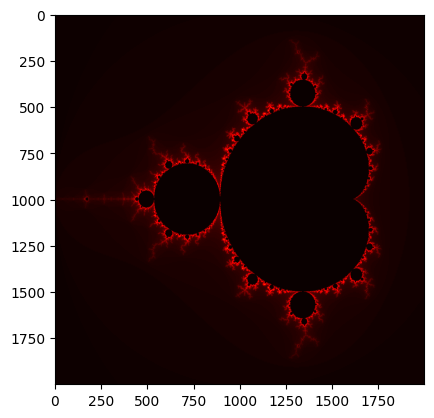

In [13]:
try:
    import matplotlib.pyplot as plt
    plt.imshow(mandelbrot_matrix(), cmap="hot")
except ImportError:
    print("matplotlib not installed, skipping plotting")

### Multi Layer Perceptron

This example is a simple MLP(Multi Layer Perceptron) with the Relu activation function. 
It uses simple matrix operations, but is split up in many different functions to showcase the need for cross-procedural analysis.
It uses nested function calls without intermediate variables, which could make it harder to track the shapes of the matrices. 

The main take-away for this exemple is validating the shapes of the series of layers : in a perfect world, we want to be able to check if the input dimensions of the dataset fit the input dimensions of the first layer, and if the output dimensions of the last layer fit the output dimensions of the dataset.

More realistically, we want to be able to check if the output dimensions of a layer fit the input dimensions of the next layer.

In [14]:
def forward(x, W, b):
    return x.dot(W) + b


def init_layer(n_in, n_out):
    W = RNG.random((n_in, n_out))
    b = RNG.random((1, n_out))
    return W, b


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return (x > 0).astype(float)


def error(x, y):
    return np.sum(x - y)
    return np.sum((x - y) ** 2)



def network_forward_1(x, W1, b1, W2, b2): # x : (batch, 2)
    x = forward(x, W1, b1)  # (batch, hidden_size)
    x = relu(x)  # (batch, hidden_size)
    x = forward(x, W2, b2)  # (hidden_size, 1)
    x = relu(x)  # (hidden_size, 1)
    return x


def network_fit_1(x, y, W1, b1, W2, b2, lr=0.01):
    layer_1 = forward(x, W1, b1)  # x : (batch, hidden_size)
    activation_1 = relu(layer_1)  # x : (batch, hidden_size)
    layer_2 = forward(activation_1, W2, b2)  # x : (batch, 1)
    activation_2 = relu(layer_2)  # x : (batch, 1)

    pred = activation_2

    err = pred - y # (batch, 1)

    m = x.shape[0] # int 
    derivative_weights_2 = 1 / m * np.dot(activation_1.T, err * relu_derivative(pred)) # (hidden_size, 1)
    derivative_bias_2 = (
        1 / m * np.sum(err * relu_derivative(pred), axis=0, keepdims=True)
    ) # (1, 1)
    derivative_weights_1 = (
        1
        / m
        * np.dot(
            x.T,
            np.dot(err * relu_derivative(pred), W2.T) * relu_derivative(activation_1),
        )
    ) # (2, hidden_size)
    derivative_bias_1 = (
        1
        / m
        * np.sum(
            np.dot(err * relu_derivative(pred), W2.T) * relu_derivative(activation_1),
            axis=0,
            keepdims=True,
        )
    ) # (1, hidden_size)

    W2 -= lr * derivative_weights_2
    b2 -= lr * derivative_bias_2
    W1 -= lr * derivative_weights_1
    b1 -= lr * derivative_bias_1

    return W1, b1, W2, b2


In [15]:
try:
    from sklearn.datasets import make_regression
    from sklearn.preprocessing import StandardScaler
    _sklearn_ok = True
except ImportError:
    _sklearn_ok = False

if _sklearn_ok:
    X, Y = make_regression(n_features=2)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    scaler2 = StandardScaler()
    Y = scaler2.fit_transform(Y.reshape(-1, 1)).ravel()
    Y = Y.reshape(-1, 1)

    hidden_size = 10
    W1, b1 = init_layer(2, hidden_size)
    W2, b2 = init_layer(hidden_size, 1)

    for i in range(100):
        W1, b1, W2, b2 = network_fit_1(X, Y, W1, b1, W2, b2)
        if i % 10 == 0:
            print("error : ", error(network_forward_1(X, W1, b1, W2, b2), Y)/X.shape[0])

error :  3.7003961451156693
error :  1.8425690401693862
error :  1.1297593864033462
error :  0.7863441700661741
error :  0.6075359222804275
error :  0.5082463991869431
error :  0.45107652211883453
error :  0.4201698648073235
error :  0.4075803778800848
error :  0.4036841070064242


## Checking the shape manually

It is possible to check the shape of a matrix manually, by using the `shape` attribute. This can be done at any point in the program, and this information can be used to deduce properties on the shape, if not the full shape.

In [16]:
def from_unknown_wrong_shape_check():
    A = ...
    B = ...

    print(A.shape, B.shape)

    if (
        A.shape[1] == B.shape[0]
    ):  # This is the opposite of the usual check, and also assumes they are 2D arrays
        return
    A @ B  # Might crash, since the check is incorrect


def from_unknown_wrong_shape_check_more_check():
    A = ...
    B = ...

    print(A.shape, B.shape)

    if (
        A.ndim == 2 and B.ndim == 2 and A.shape[1] == B.shape[0]
    ):  # This is the opposite of the usual check
        return
    A @ B  # Might crash, since the check is incorrect


# from_unknown_wrong_shape_check()
# from_unknown_wrong_shape_check_more_check()

## Getting a bound on the shape from the axis parameter

Some functions in Numpy have an `axis` parameter, which if successful, can give us a minimum bound on the number of dimensions of both input and output matrix

In [17]:
def axis_deduce_bounds_1(A):
    return np.sum(A, axis=1) # If this works, then ndim >= 1 + 1

def axis_and_einsum_mismatch(A):
    _ = np.einsum("ij,jk->ik", A, A)
    return np.sum(A, axis=2)
    # Here, we have conflicting information : A is supposed to be 2D from the einsum string, but reducing on axis=2 implies that A is 3D
    # Since we are reducing on axis=2, the result will have one less dimension

axis_deduce_bounds_1(RNG.random((5, 5)))
axis_deduce_bounds_1(RNG.random((5, 5, 5)))
# axis_deduce_bounds_1(RNG.random((5,))) # AxisError: axis 1 is out of bounds for array of dimension 1

array([[2.60302057, 2.98194327, 2.24668896, 3.44594005, 3.07928416],
       [2.16479353, 2.95304034, 1.91969777, 2.88865959, 1.35744012],
       [2.95140571, 2.15280808, 2.17996253, 3.29379911, 3.1539108 ],
       [1.07650496, 1.16490423, 2.45392904, 1.50674511, 2.4185856 ],
       [2.841753  , 2.52673615, 3.01009441, 2.97484554, 1.39683728]])

## Using partial knowlege to infer intermediary steps

In order to tackle real-worl cases, it is important to be able to infer the shapes of intermediary steps when possible, to be able to use them in further operations.

Here, we have a 3 matrices that are multiplied together, but we only know the shape of the first and last one. It is possible to infer the shape of the intermediary matrix by using the shape of the other two matrices.
This way, we can raise issues when reusing the middle matrix in further operations.

In [18]:
def with_a_third_unknown(B: np.ndarray):
    A = RNG.random((3, 4))
    C = RNG.random((4, 5))

    A @ B @ C  # Might work, if B is (4,4)


def inferrerable_with_a_third_unknown_reused(B):
    A = RNG.random((3, 4))
    C = RNG.random((4, 5))

    A @ B @ C  # Might work, if B is (4,4)

    D = RNG.random((4, 4))
    B @ D  # Will work if we did not crash before, since the shape of B can be inferred


with_a_third_unknown(RNG.random((4, 4)))  # OK
# with_a_third_unknown(np.random.rand(4, 5)) # Crash

inferrerable_with_a_third_unknown_reused(RNG.random((4, 4)))  # OK
# inferrerable_with_a_third_unknown_reused(np.random.rand(4, 5)) # Crash

## Eventual `np.trace` rule

Mathematically, the trace is defined to be the sum of all the diagonal elements of a square matrix. Numpy extends this definition to non-square matrices.
This was raised [on the official Numpy repository](https://github.com/numpy/numpy/issues/25391), where it was not very well received. 

I think this rule could be specified, as long as we find an alternative for non-square matrices to replace it.

In [19]:
def needs_square_trace():
    A = RNG.random((25, 25))
    A.trace()


def needs_square_trace_strange_behavior():
    A = RNG.random((5, 26))
    A.trace()  # Might expect a crash since it is not square, but numpy returns a result anyway


needs_square_trace()
needs_square_trace_strange_behavior()

## The Einstein summation convention

The Einstein summation convention (einsum) is a compact representation of sums of products for multidimensional matrices. It is a very powerful tool, and comes with its own DSL. It can be used to represent a lot of different operations, from the trace to matrix multiplication.

While it is not possible to get the complete shape of the matrices involved, in most case, it is possible to get the number of dimensions.

The DSL differs between libraries. For exemple, in Numpy, the `...` operator is used to represent broadcasting. In PyTorch, not all the operations are supported.

A rule checking the validity of the einsum string could be useful.

[Here](https://rockt.github.io/2018/04/30/einsum) is a website that explains it pretty well.

In [20]:
def einsum_trace():
    A = RNG.random((100, 100))
    assert np.allclose(np.einsum("ii->", A), np.trace(A))

def einsum_trace_ellipsis():
    A = RNG.random((100, 100))
    assert np.allclose(np.einsum("...ii->...", A), np.trace(A))

def einsum_sum_ellipsis_broadcast():
    A = RNG.random((456,23,2,2))
    einsum = np.einsum("...ii->...", A)
    print(A[0,0,:])
    print(einsum[0, 0])
    assert np.allclose(einsum, np.trace(A, axis1=-2, axis2=-1))
    assert einsum.shape == (456, 23)

def einsum_sum_product():
    A = RNG.random((100, 100))
    B = RNG.random((100, 100))
    # Elementwise product
    assert np.allclose(np.einsum("ij,ij->", A, B), np.sum(A * B))

def einsum_tensor_product():
    A = RNG.random((100, 100))
    B = RNG.random((100, 100))
    # Matrix/tensor product
    assert np.allclose(np.einsum("ij,jk->ik", A, B), A @ B)

def einsum_complicated():
    A = RNG.random((100, 100))
    B = RNG.random((100, 100))
    C = RNG.random((100, 100))
    # Complicated einsum
    assert np.allclose(np.einsum("ij,jk,kl->il", A, B, C), A @ B @ C)

# With einsum, the number of letters for each matrix gives us its number of dimensions, except when there is an ellipsis
# The DSL is slightly different for each matrix library, some like Pytorch don't support everything

einsum_trace()
einsum_trace_ellipsis()
einsum_sum_ellipsis_broadcast()
einsum_sum_product()
einsum_tensor_product()
einsum_complicated()

[[0.53633843 0.43262932]
 [0.8309878  0.16599534]]
0.702333774454683


## Vectors

Vectors are a special case of matrices, and some patterns happen very often, such as using their transpose.

In [21]:

def vector_scalar_from_array():
    X = np.array([1, 2, 3])
    np.dot(X, X.T)


def vector_scalar_from_ravel():
    A = np.array([[1, 2, 3], [4, 5, 6]])
    X = A.ravel()
    np.dot(X, X.T)


def vector_scalar_from_flatten():
    A = np.array([[1, 2, 3], [4, 5, 6]])
    X = A.flatten()
    np.dot(X, X.T)


vector_scalar_from_array()
vector_scalar_from_ravel()
vector_scalar_from_flatten()

## Tensors and higher dimensions with linear algebra

Tensors (matrices with more than 2 dimensions) are a generalization of matrices, and can be used in a similar way with most linear algebra functions. However, they will be interpreted as a stack of matrices, and the operations will be applied to each of them.

For exemple, the `np.linalg.det`  will 'remove' the last 2 dimensions of the tensor, and replace them with just the determinant (a scalar).

In [22]:
def tensor_linalg_det():
    A = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9,10], [11, 12]]]) # (3, 2, 2)
    return np.linalg.det(A) # (3,) because we have a stack of 3 2x2 matrices
    # The last 2 dimensions are removed, they are replaced by a scalar
def tensor_linalg_det_explicit_shape():
    A = RNG.random((25, 4, 3, 8, 8)) # The last 2 dimensions must be square (equal)
    assert np.linalg.det(A).shape == (25, 4, 3) # The last 2 dimensions are removed

tensor_linalg_det()
tensor_linalg_det_explicit_shape()

### Tensordot shapes

The `tensordot` function can be used in multiple ways, and inferring the shape of the output tensor can be quite complex.

In [23]:
def tensordot_axis0():
    a = RNG.random((3, 4))
    b = RNG.random((5, 6, 7, 8))
    result_axis0 = np.tensordot(a, b, axes=0)
    assert result_axis0.shape == (3, 4, 5, 6, 7, 8)

def tensordot_axis1():
    a = RNG.random((3, 4, 5))
    b = RNG.random((5, 6, 7))
    result_axis1 = np.tensordot(a, b, axes=1)
    assert result_axis1.shape == (3, 4, 6, 7)

def tensordot_axis2():
    a = RNG.random((3, 4, 5, 6))
    b = RNG.random((5, 6, 7, 8))
    result_axis2 = np.tensordot(a, b, axes=2)
    assert result_axis2.shape == (3, 4, 7, 8)

tensordot_axis0()
tensordot_axis1()
tensordot_axis2()

## Universal functions (ufuncs) and vectorization

Numpy has a lot of universal functions, which are functions that can be applied to a matrix and interpret it correctly. Most of the functions are written in C, and are very optimized. 

It is possible to write custom ufuncs from python, but all the capabilities can not be used.

In [24]:
square = np.frompyfunc(lambda x: x*x, 1, 1)
square_res = square(np.arange(10))

# This ufunc gives no information about shape, but with frompyfunc, the dtype always becomes object

assert square_res.dtype == object
assert np.allclose(square_res.astype(int), np.arange(10)**2)

### `np.vectorize`

`np.vectorize` is a function that can be used to vectorize a function. It is possible to specify the signature of the function, which is verified at runtime.

In [25]:
def square_vectorize(x):
    return x ** 2

f = np.vectorize(square_vectorize, signature="(n)->(n)") # There is a signature that allows us to infer at least some of the shape
assert np.allclose(f(np.arange(10)), np.arange(10)**2)

In [26]:
def vectorized_tensor_product(s1, s2):
    A = RNG.random(s1)
    B = RNG.random(s2)
    f = np.vectorize(lambda x, y: x @ y, signature="(n,m),(m,p)->(n,p)") # More complex signature
    assert np.allclose(f(A, B), A @ B)

vectorized_tensor_product((10, 5), (5, 10))
vectorized_tensor_product((10, 5, 5), (10, 5, 5))

# vectorized_tensor_product((10, 5, 5), (10, 1000, 5)) # ValueError: inconsistent size for core dimension 'm': 1000 vs 5

## From typehints

At the moment of writing, there are no definite ways to specify the shape from type hints. However, with https://github.com/numpy/numpy/issues/16544 and https://peps.python.org/pep-0646/, it will most likely be possible in the future

They could like like `Array[H, W, Literal[3], int64]` for exemple. All of them will rely on the new `TypeVarTuple` typing utility.

# Conclusion

It is possible to extract a lot of information from Numpy programs, especially when it comes to the shape of the matrices. However, it is not always possible to get the full shape, and sometimes we have to rely on partial information.
The hope is to use DBD to extract all that information, and perform all the constraint checking (possibly with the help of a SMT solver).

A lot of this work is going to be relevant for other libraries, since most of them expose either a `numpy`-compatible API, or are very similar in their behavior.